
=== Running QBA for arbitrary size N=5 ===
Constraint (2N-1): 9
Selected workspace: 4 qubits (M=16)


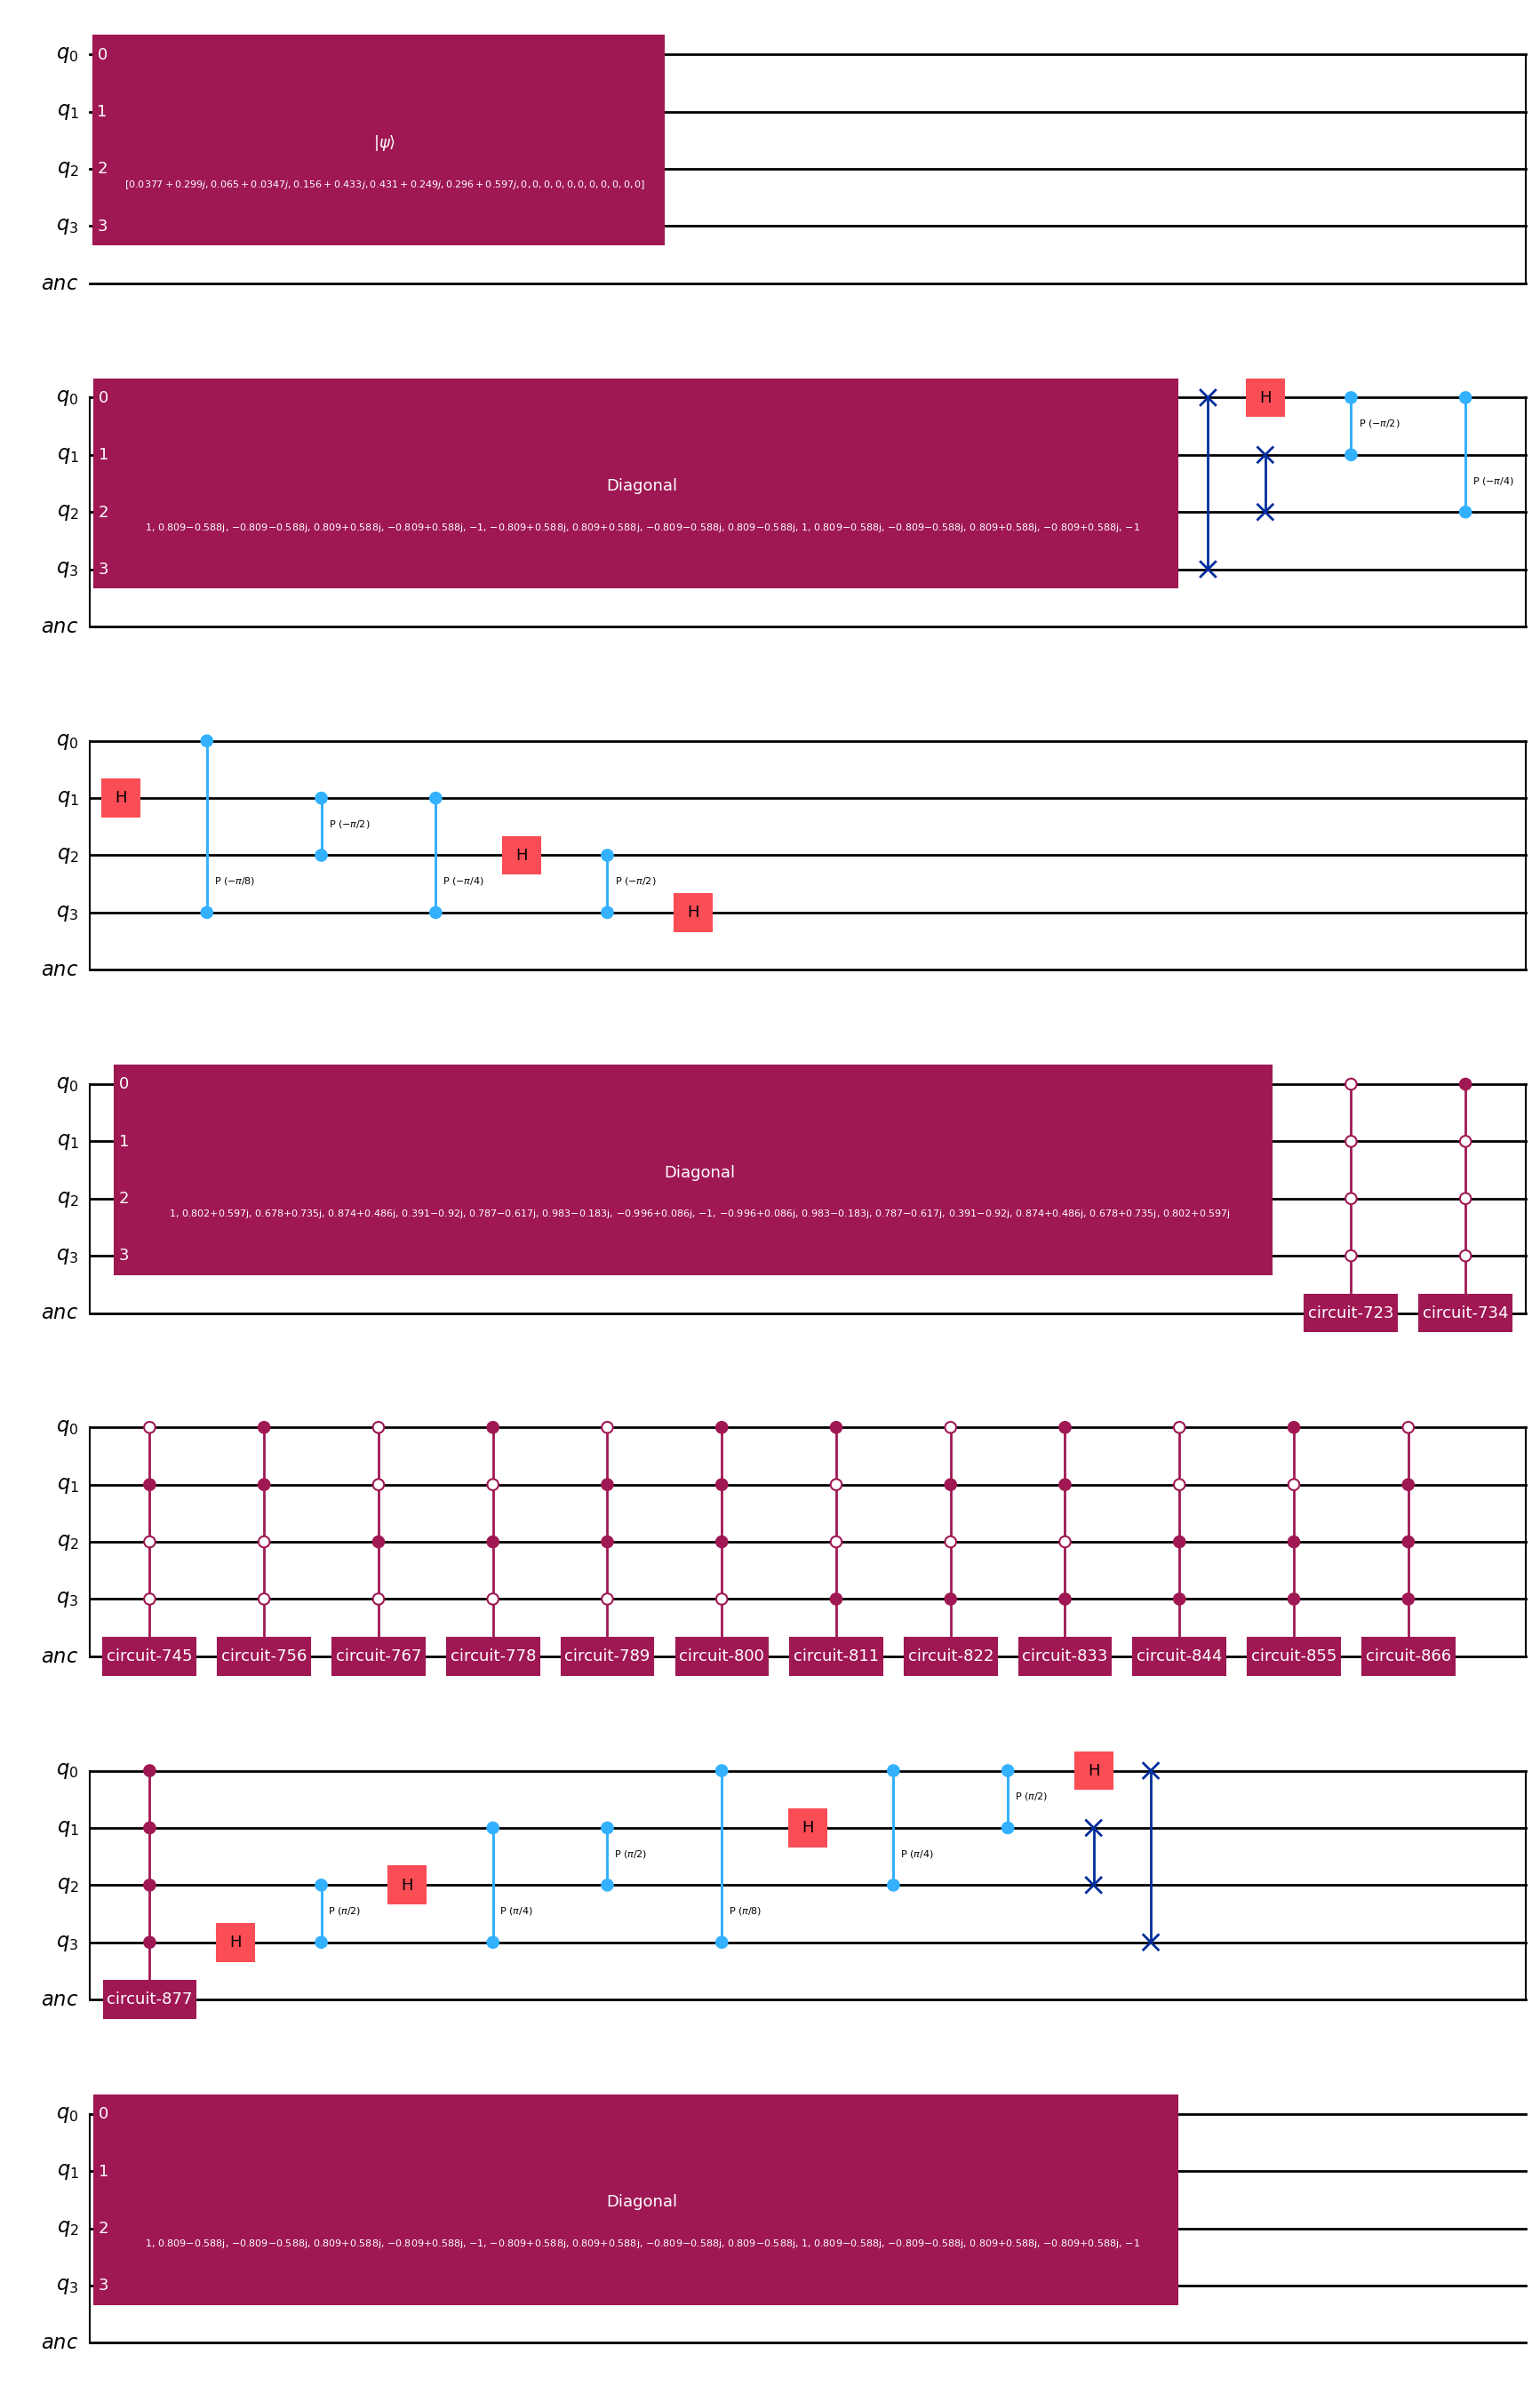

Circuit built. Simulating statevector...

Simulation histogram


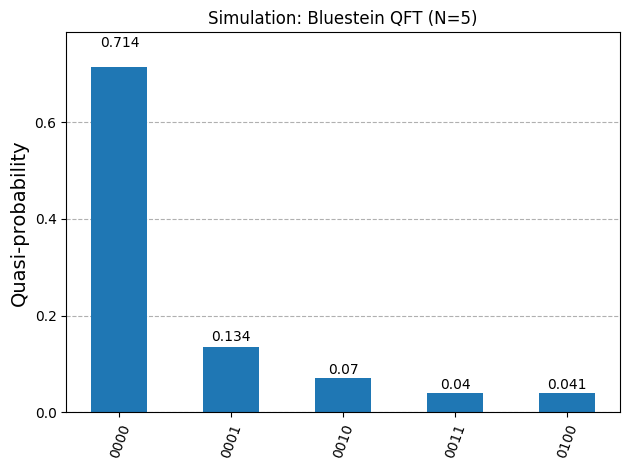


--- Results (state amplitudes) ---
Target:  [ 0.441131+0.721034j -0.336544+0.145035j -0.258978-0.056656j
  0.193421+0.054983j  0.045267-0.196095j]
Quantum: [ 0.441131+0.721034j -0.336544+0.145035j -0.258978-0.056656j
  0.193421+0.054983j  0.045267-0.196095j]

Max Error: 1.37e-15
SUCCESS: True


In [4]:
# Copyright: Renata Wong (2025)
# Qiskit code, compatible with Qiskit v.2.0 and later

# Supports both simulation and execution on quantum hardware
# By default, the input state is generated randomly


import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DiagonalGate
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram



# =============================================================================
# 1. HELPER FUNCTIONS: MANUAL QFT IMPLEMENTATION
# =============================================================================
# We implement the QFT manually to ensure strict control over:
#   1. The direction of rotation (FFT vs IFFT).
#   2. The placement of SWAP gates (bit-ordering).
# This avoids ambiguity found in standard libraries regarding definitions.

def apply_fft(qc, qubits):
    """
    Implements the forward DFT (FFT).
    Mathematical definition: y_k = sum(x_j * e^(-2*pi*i*j*k / M))
    
    In terms of quantum gates, this is the inverse of the standard QFT.
    Since standard QFT (IFFT) = swaps * gates, 
    The inverse QFT (FFT)     = gates_dagger * swaps.
    """
    n = len(qubits)
    
    # 1. SWAP gates first
    # We swap the inputs to correctly implement the adjoint of the standard QFT.
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - 1 - i])
        
    # 2. Inverse QFT layers (Hadamard + negative rotations)
    # We iterate forward (0 to n) matching the inverse structure.
    for i in range(n):
        qc.h(qubits[i]) # Hadamard
        for j in range(i + 1, n):
            # Controlled Phase (CP) with negative angle for FFT behavior
            # Angle = -pi / 2^(distance)
            theta = -np.pi / (2 ** (j - i))
            qc.cp(theta, qubits[j], qubits[i])

def apply_ifft(qc, qubits):
    """
    Implements the inverse DFT (IFFT).
    Mathematical definition: y_k = sum(x_j * e^(+2*pi*i*j*k / M))
    
    This corresponds to the standard QFT circuit structure:
    Standard QFT = swaps * gates.
    """
    n = len(qubits)
    
    # 1. Forward QFT layers (Hadamard + positive rotations)
    # Standard QFT construction usually iterates in reverse for the gates.
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            # Controlled Phase (CP) with positive angle for IFFT behavior
            theta = np.pi / (2 ** (j - i))
            qc.cp(theta, qubits[j], qubits[i])
        qc.h(qubits[i]) 
        
    # 2. SWAP gates last
    # Standard QFT ends with swaps to fix bit-reversal.
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - 1 - i])






# =============================================================================
# 2. MAIN ALGORITHM: QUANTUM BLUESTEIN'S (QBA)
# =============================================================================

def run_qba(N, simulation = True):
    """
    Executes the Quantum Bluestein's Algorithm for an arbitrary input size N.
    If simulation = True, a simulation will be performed.
    If simulation = False, an execution on a real backend will be performed.
    """
    print(f"\n=== Running QBA for arbitrary size N={N} ===")

    # --- Step 1: Padding ---
    # To perform linear convolution of size N using FFTs (which do circular convolution),
    # we must zero-pad the space to size M >= 2N - 1.
    min_size = 2 * N - 1
    m = int(np.ceil(np.log2(min_size))) # number of qubits
    M = 2**m                            # Hilbert space size
    
    print(f"Constraint (2N-1): {min_size}")
    print(f"Selected workspace: {m} qubits (M={M})")

    
    # --- Step 2: Classical pre-computation ---
    # We pre-calculate the diagonal phase vectors required for the algorithm.
    
    # A. Generate random normalized input vector (for demonstration)
    x_in = np.random.rand(N) + 1j * np.random.rand(N)
    x_in /= np.linalg.norm(x_in) # must be a valid quantum state
    
    # B. Chirp vectors (quadratic phases)
    # Input chirp:  a_j = x_j * e^(-i * pi * j^2 / N)
    chirp_in = np.array([np.exp(-1j * np.pi * (j**2) / N) for j in range(M)])
    
    # Output de-chirp: X_k = y_k * e^(-i * pi * k^2 / N)
    chirp_out = np.array([np.exp(-1j * np.pi * (k**2) / N) for k in range(M)])

    # C. Convolution kernel (Bluestein's sequence)
    # Kernel: b_t = e^(i * pi * t^2 / N)
    # IMPORTANT: We must wrap this sequence for circular convolution.
    # Indices 0 to N-1 are standard. Negative indices wrap to M-1 downwards.
    b_vec = np.zeros(M, dtype=complex)
    for t in range(N):
        val = np.exp(1j * np.pi * (t**2) / N)
        b_vec[t] = val
        if t > 0: 
            b_vec[M-t] = val # Wrap b[-t] to b[M-t]

    # D. Kernel spectrum (frequency domain)
    # We compute the FFT of the kernel classically. This forms the diagonal operator
    # for the convolution step.
    b_tilde = np.fft.fft(b_vec)
    
    # Normalize for unitary block encoding
    # We divide by the max amplitude (alpha) to ensure all values are <= 1.
    # The "lost" probability is handled by post-selection on the ancilla.
    alpha = np.max(np.abs(b_tilde))
    normalized_b_tilde = b_tilde / alpha

    
    # --- Step 3: Quantum circuit construction ---
    qr = QuantumRegister(m, 'q')       # workspace qubits
    anc = QuantumRegister(1, 'anc')    # ancilla for block encoding
    if simulation == False:
        c = ClassicalRegister(m+1, 'c')
        qc = QuantumCircuit(qr, anc, c)
    else:
        qc = QuantumCircuit(qr, anc)

    # A. State initialization
    # Embed the length-N input into the length-M zero-padded state |psi_in>.
    input_padded = np.zeros(M, dtype=complex)
    input_padded[:N] = x_in
    qc.initialize(input_padded, qr)

    # B. Input chirp
    # Apply diagonal unitary D1: |j> -> e^(-i*pi*j^2/N) |j>
    qc.append(DiagonalGate(chirp_in), qr)

    # C. Forward FFT
    # Move to the frequency domain to turn convolution into multiplication.
    # Uses our manual function (negative exponents).
    apply_fft(qc, qr)

    # D. Convolution (block encoding)
    # We implement the diagonal operator U_conv = diag(b_tilde).
    # Since b_tilde is not unitary (magnitudes != 1), we use block encoding.
    
    # Part 1: Apply the phases (unitary)
    # |k> -> e^(i * arg(b_tilde_k)) |k>
    qc.append(DiagonalGate(np.exp(1j * np.angle(normalized_b_tilde))), qr)
    
    # Part 2: Apply the magnitudes (non-unitary via ancilla)
    # We perform a controlled-rotation on the ancilla such that:
    # <0| U |0> = |b_tilde_k|
    magnitudes = np.abs(normalized_b_tilde)
    # clipping makes sure that rounding errors don't lead to values that are smaller than 0 or larger than 1
    magnitudes = np.clip(magnitudes, 0.0, 1.0)
    thetas = 2 * np.arccos(magnitudes) # angle for Ry gate
    
    for k in range(M):
        # Optimization: only add gate if rotation is non-trivial
        if abs(thetas[k]) > 1e-10:
            c_ry = QuantumCircuit(1)
            c_ry.ry(thetas[k], 0)
            # Create a multi-controlled gate that activates only for state |k>
            custom_gate = c_ry.to_gate().control(m, ctrl_state=k)
            qc.append(custom_gate, list(qr) + [anc])

    # E. Inverse FFT
    # Return to time domain. Uses our manual function (positive exponents).
    apply_ifft(qc, qr)

    # F. Output de-chirp
    # Apply diagonal unitary D2: |k> -> e^(-i*pi*k^2/N) |k>
    qc.append(DiagonalGate(chirp_out), qr)

    if simulation == False: 
        # Map ancilla to the Most Significant Bit (c[m]) for easier filtering
        qc.measure(anc, c[m]) 
        # Map data qubits to the lower bits
        qc.measure(qr, c[0:m])

    # Draw the circuit
    display(qc.draw('mpl'))
    figure = qc.draw(output='mpl', scale=0.6)

    # Save the figure object using standard matplotlib commands
    figure.savefig('qba.jpg', dpi=300)

    # --- Step 4: Verification ---
    # Execution on a simulator
    if simulation == True:
        print("Circuit built. Simulating statevector...")
        state = Statevector.from_instruction(qc)
        raw_data = np.asarray(state)
    
        # Extract result (post-selection)
        # We only keep the branch where the ancilla qubit is |0>.
        # This realizes the non-unitary convolution operation.
        vector_result = np.zeros(N, dtype=complex)
        fmt = f'0{m+1}b' # format string for bitstrings (e.g., '00101')
        
        for i in range(len(raw_data)):
            bitstr = format(i, fmt)
            # In Qiskit tensor product, ancilla was added last, 
            # but check bitstr[0] (MSB) for safety in standard sorting.
            if bitstr[0] == '0': # ancilla is 0
                idx = int(bitstr[1:], 2) # remaining bits are the data index
                if idx < N:      
                    vector_result[idx] = raw_data[i]
    
        # Normalize quantum result (to compare with theory)
        q_norm = vector_result / np.linalg.norm(vector_result)

        # === VISUALIZATION FOR SIMULATION ===
        # Calculate probabilities from normalized complex amplitudes
        sim_counts = {}
        for i in range(N):
            prob = np.abs(q_norm[i])**2
            # Create a label for valid indices (length m, excluding ancilla)
            state_label = format(i, f'0{m}b')
            sim_counts[state_label] = prob
            
        print("\nSimulation histogram")
        display(plot_histogram(sim_counts, title=f"Simulation: Bluestein QFT (N={N})"))
        
        # Calculate classical target (standard FFT)
        target = np.fft.fft(x_in)
        target_norm = target / np.linalg.norm(target)
    
        # Robust phase alignment
        # Quantum states are unique up to a global phase. We rotate our result
        # to match the target's phase at the index with the largest amplitude.
        max_idx = np.argmax(np.abs(target_norm))
        if abs(target_norm[max_idx]) > 1e-9:
            diff = np.angle(target_norm[max_idx]) - np.angle(q_norm[max_idx])
            q_aligned = q_norm * np.exp(1j * diff)
        else:
            q_aligned = q_norm
            
        # Print outcomes
        print("\n--- Results (state amplitudes) ---")
        print(f"Target:  {np.round(target_norm, 6)}")
        print(f"Quantum: {np.round(q_aligned, 6)}")
        
        max_err = np.max(np.abs(q_aligned - target_norm))
        print(f"\nMax Error: {max_err:.2e}")
        success = max_err < 1e-6

        return success

    # Execution on quantum backend
    # Assume 'qc' is your Bluestein circuit with the ancilla measured
    # The ancilla is usually the first bit (or last, depending on bit ordering)
    if simulation == False:
        # 1. Run on hardware
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
        sampler = Sampler(mode=backend)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
        isa_circuit = pm.run(qc)
        job = sampler.run([isa_circuit], shots=10000)
        print(f"Job submitted: {job.job_id()}")
        result = job.result()
        pub_result = result[0] 
        counts = pub_result.data.c.get_counts()
    
        # 4. Correct Post-selection
        # Qiskit prints bitstrings as "c[m] ... c[0]" (High index to Low index)
        # Since we mapped ancilla to c[m], it will be the FIRST character (Index 0).
        
        post_selected_counts = {}
        total_shots = 0
        success_shots = 0
        
        print("\n--- Processing results ---")
        
        for bitstring, count in counts.items():
            # Check the MSB (Ancilla)
            ancilla_state = bitstring[0] 
            
            if ancilla_state == '0': # Algorithm Success
                # The rest of the string is our data (c[m-1]...c[0])
                data_part = bitstring[1:] 
                post_selected_counts[data_part] = post_selected_counts.get(data_part, 0) + count
                success_shots += count
            
            total_shots += count

        # FILTERING STEP: Keep only valid indices 0 to N-1
        final_counts = {}
        for bitstring, count in post_selected_counts.items():
            # Convert bitstring to integer index
            idx = int(bitstring, 2)
            
            # ONLY keep if index is within our problem size N
            if idx < N:
                final_counts[bitstring] = count
        
        
                
        # 6. CALCULATE & DISPLAY METRICS
        # ---------------------------------------------------------
        selection_rate = (success_shots / total_shots) * 100
        
        print(f"Total Shots: {total_shots}")
        print(f"Successful Post-selected Shots: {success_shots}")
        print(f"Selection Rate: {selection_rate:.2f}%")
        print("\nFinal Post-selected Counts (First 5):")
        for k in list(post_selected_counts.keys())[:5]:
            print(f"  {k}: {post_selected_counts[k]}")
        
        # You can now plot 'post_selected_counts' using plot_histogram
        print(f"Filtered Results (N={N}): {final_counts}")
        display(plot_histogram(final_counts, title=f"Bluestein QFT (N={N})"))
        return True

    
    

# =============================================================================
# 3. EXECUTION
# =============================================================================

success = run_qba(5)
print(f"SUCCESS: {success}")


---

Execution on IBM backend

In [ ]:
success = run_qba(5, False)